In [1]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
#from modules import calc_spinylm as sylm
#from modules import local_eb_kernel as rko
from modules import euler as euler
from modules import rs_rad_ker as rk
from modules import qu2eb_operator as qb
from scipy.interpolate import interp1d


%pylab notebook
import time

Populating the interactive namespace from numpy and matplotlib


In [73]:
nside=32 ; npix=h.nside2npix(nside)
sampling=3500
lmax=2*nside
theta_cutoff=0.4
pxsize=sqrt(4.*pi/h.nside2npix(nside))
print min(180,180.*32/lmax)*pi/180.

theta,pl2=rk.get_plm0(lmax,sampling,theta_max=pi)

#cltemp=h.read_cl("../../data/planck_wp_highL_lensing_param.fits")
cltemp=h.read_cl("../../data/cl_rem3.fits")
cllens=[cltemp[0],cltemp[1],cltemp[2]*100.,cltemp[3]*0]
random.seed(0) ; tqu=h.synfast(cllens,nside,lmax=lmax,mmax=lmax,pol=True,new=True,verbose=False)
alm=h.map2alm(tqu,lmax=lmax)
teb=h.alm2map(alm,nside,pol=False)
cl=h.alm2cl(alm)

1.57079632679
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [74]:
apow=rk.fn_apodization(theta,theta_cutoff=pi,apow_frac=0.01)
rad_ker=rk.calc_qu2eb_rad_ker(lmax,theta,pl2)# Default
#rad_ker=rk.mod_rad_ker(theta,shift=-0.01,amp=100,width=0.008,slope=2)*1000. # Modified

<IPython.core.display.Javascript object>


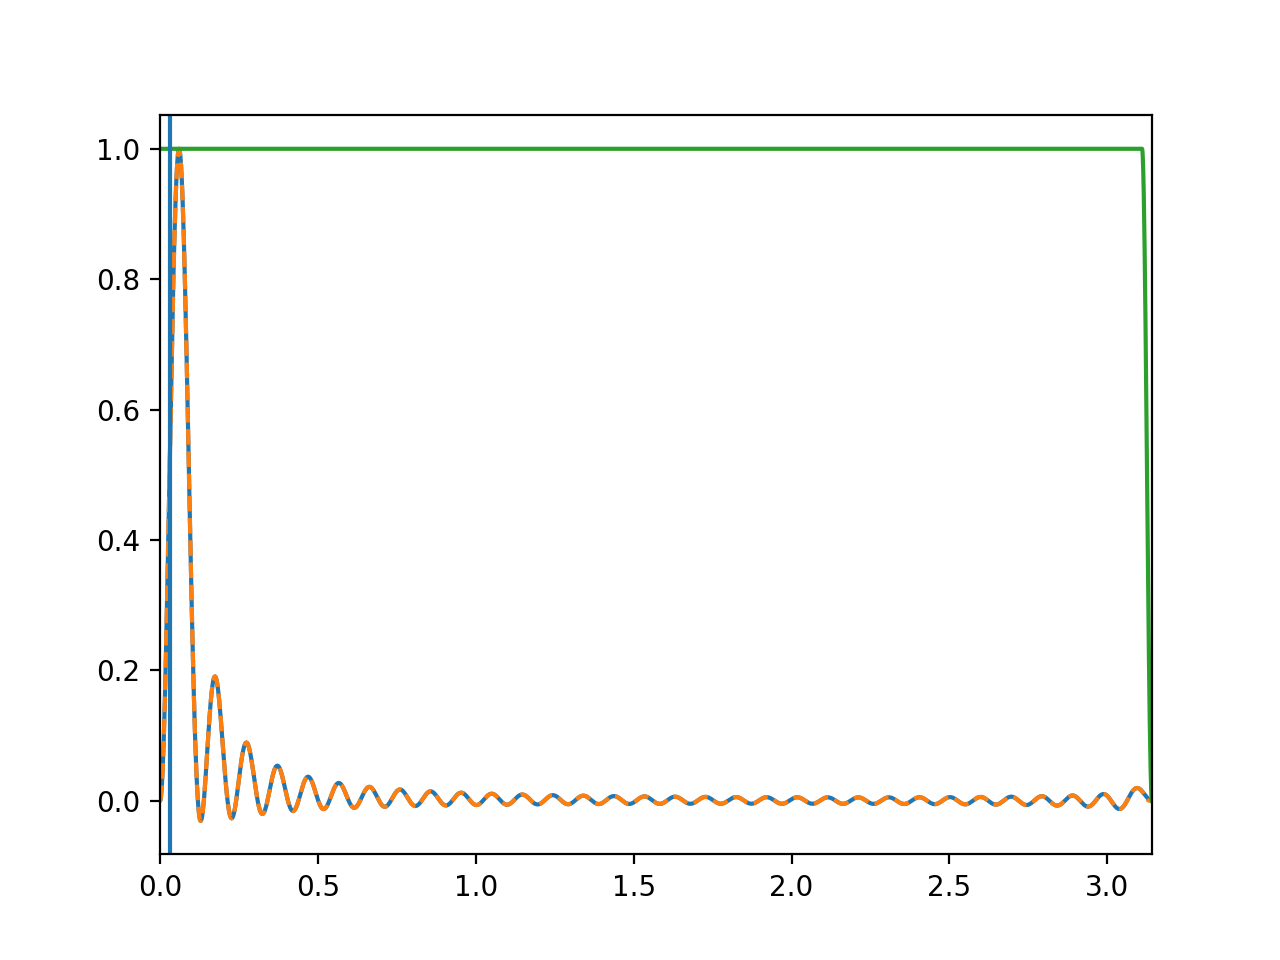

In [75]:
figure()
plot(theta,rad_ker/max(rad_ker))
plot(theta,rad_ker*apow/max(rad_ker*apow),"--")
plot(theta,apow)
axvline(pxsize)
xlim(0,pi)
rad_ker=rad_ker*apow

In [76]:
ell=arange(lmax+1)
gl=rk.get_gl_from_gbeta(theta,rad_ker,pl2,pi,lmax) ; gl[0:2]=1
rec_rad_ker=rk.get_gbeta_from_gl(theta,gl,pl2)

<IPython.core.display.Javascript object>


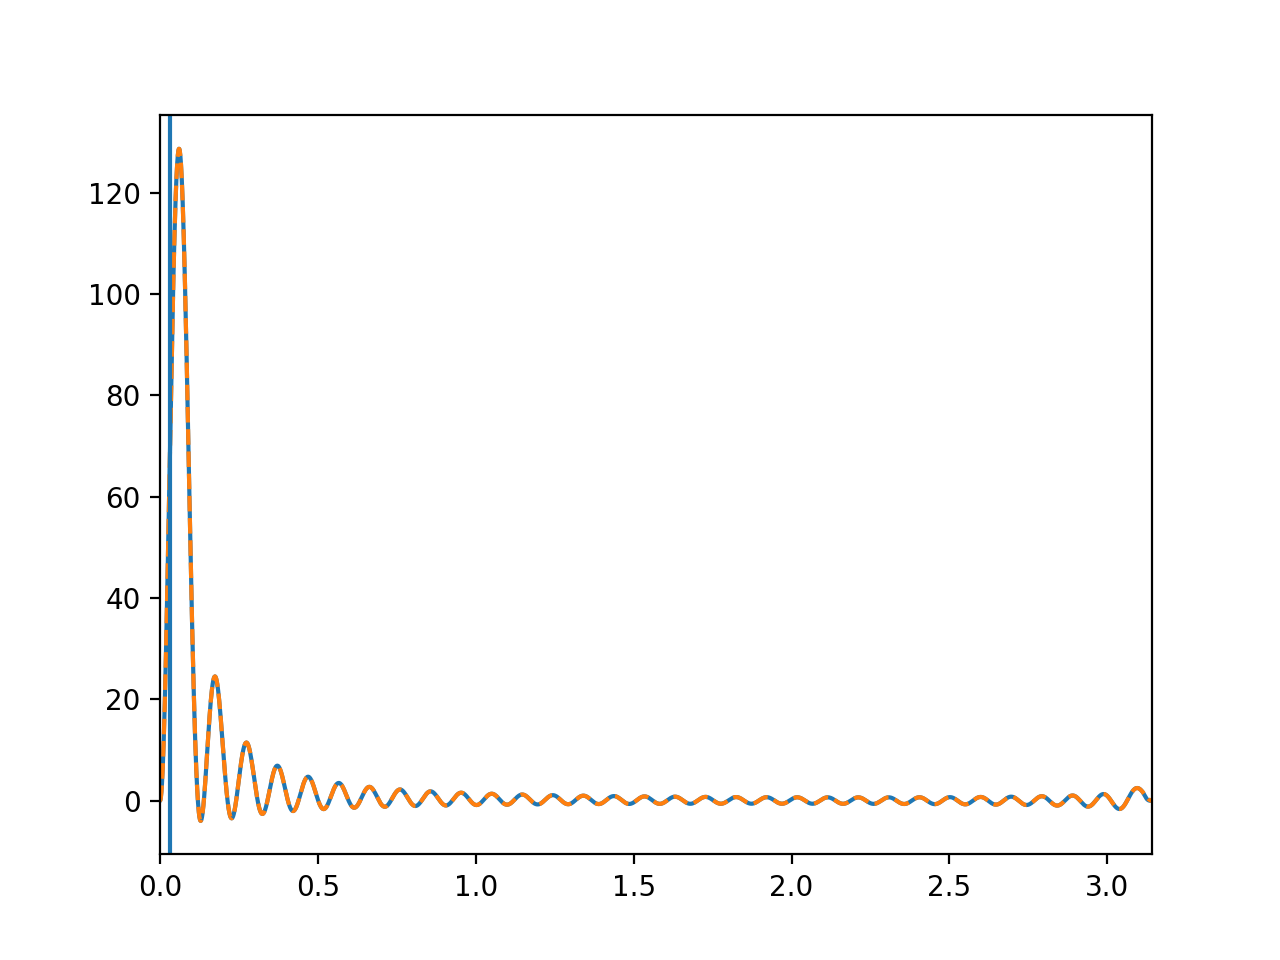

(0, 3.141592653589793)

In [77]:
figure()
plot(theta,rad_ker)
plot(theta,rec_rad_ker,"--")
axvline(pxsize)
xlim(0,pi)
#loglog()

#figure()
#plot(arange(lmax+1),gl)
#plot(arange(lmax+1),1./gl)
#axhline(0)
#loglog()

In [78]:
mask=np.ones(h.nside2npix(nside),float)
ang0=h.pix2ang(nside,arange(h.nside2npix(nside)))[0]
bw=40
mask[ang0<(90.-bw/2.)*pi/180.]=0. ; mask[ang0>(90.+bw/2.)*pi/180.]=0.
mask[:]=1.
#h.mollview(mask)
fsky=sum(mask)/size(mask) ; print fsky

1.0


#theta0=2.*pi/180. ; phi0=0.
#cpix=h.ang2pix(nside,theta0,phi0)
#tqu=[zeros(npix,float),zeros(npix,float),zeros(npix,float)] ; tqu[2][cpix]=1.
#alm=h.map2alm(tqu,lmax=lmax)
#teb=h.alm2map(alm,nside,pol=False)
#cl=h.alm2cl(alm)

In [79]:
t1=time.time()
rteb=qb.convert_qu2eb_integrate(tqu[1],tqu[2],pi,theta,rad_ker)
print time.time()-t1

t1=time.time()
rtebo=qb.convert_qu2eb_radiate(tqu[1],tqu[2],pi,theta,rad_ker)
print time.time()-t1

39.5855169296
38.069437027


<IPython.core.display.Javascript object>


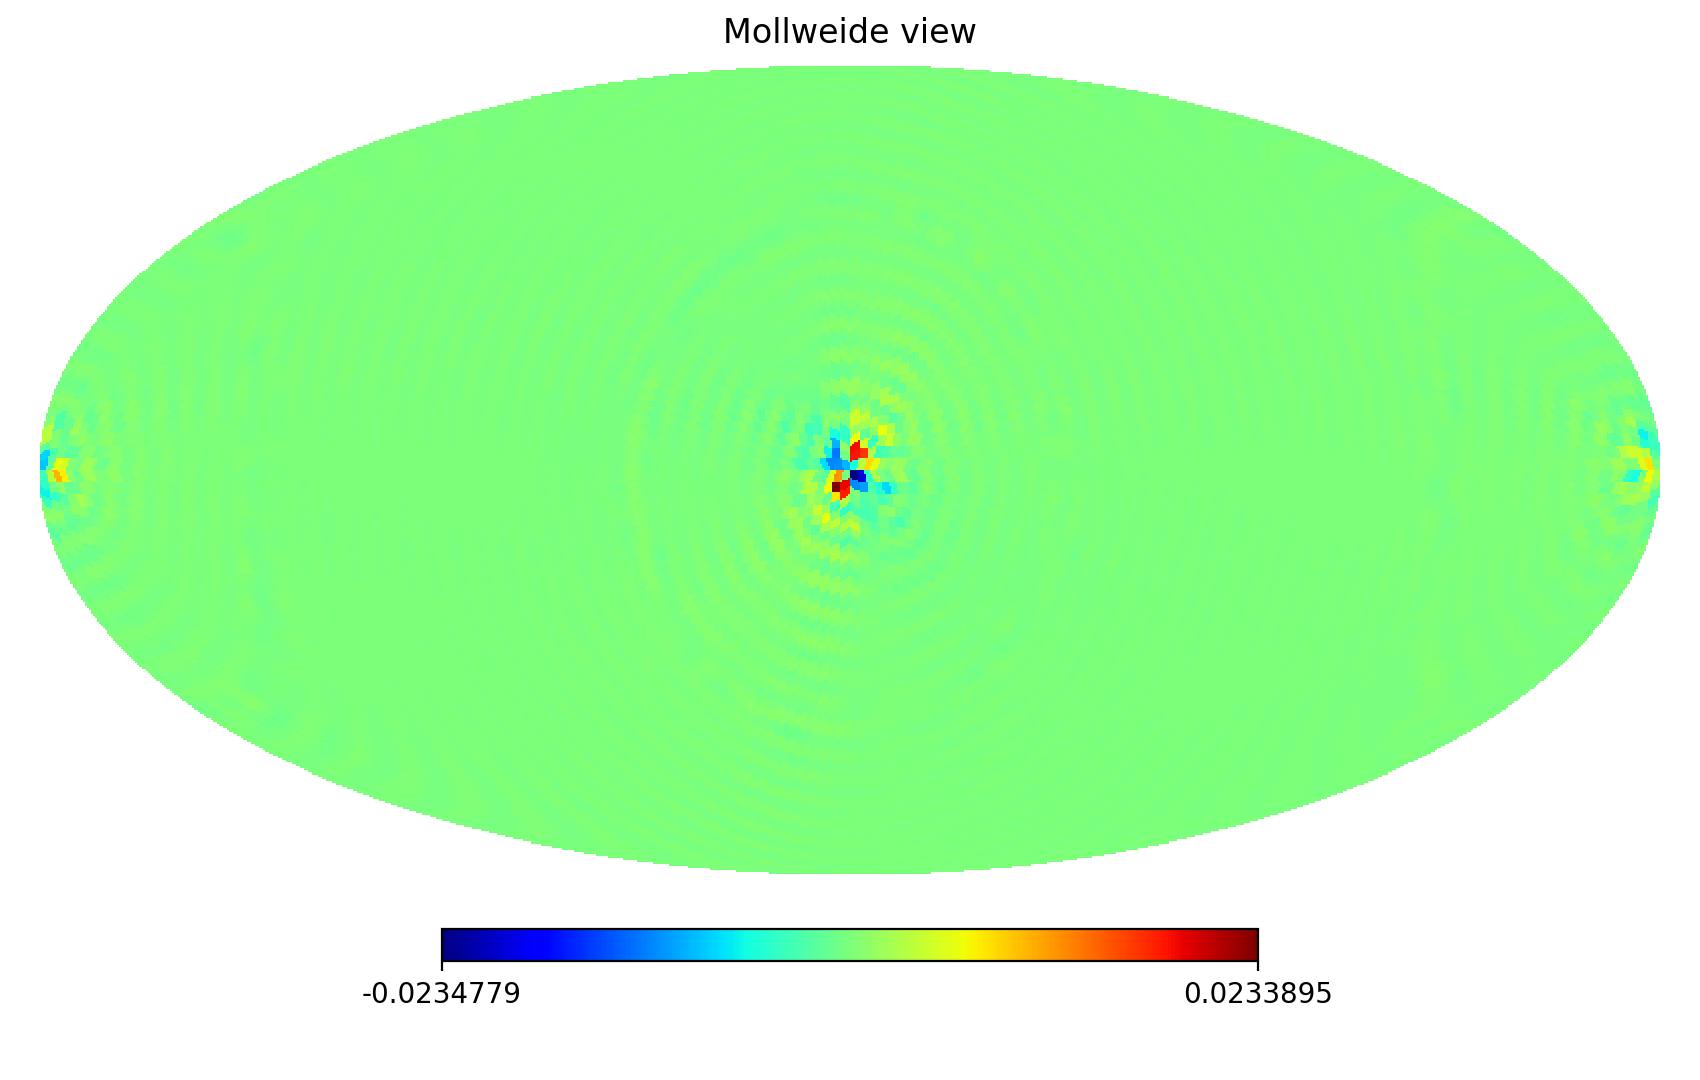

<IPython.core.display.Javascript object>


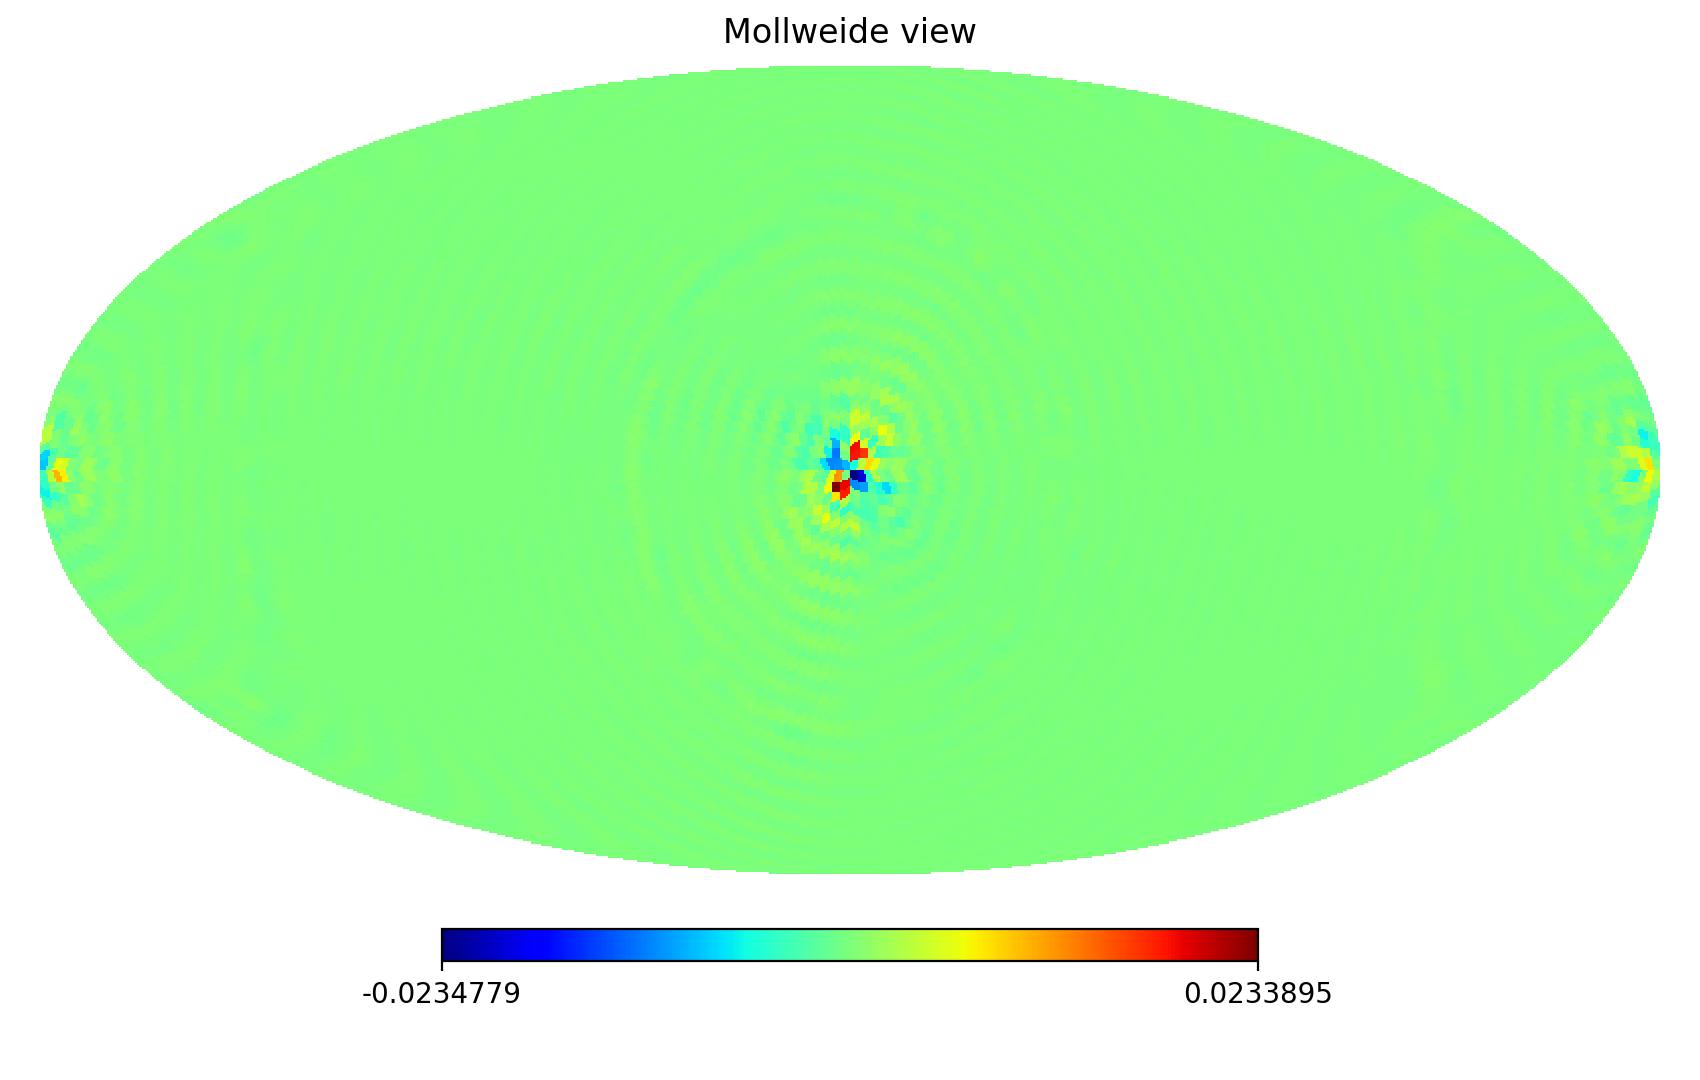

In [81]:
#h.mollview(teb[2],rot=(0,90))#,rot=(phi0*180./pi,90-theta0*180./pi))
h.mollview(rteb[2]-teb[2],rot=(0,90))#,rot=(phi0*180./pi,90-theta0*180./pi))
h.mollview(rtebo[2]-teb[2],rot=(0,90))#,rot=(phi0*180./pi,90-theta0*180./pi))


#h.mollview(rtebo[2],rot=(0,90))#,rot=(phi0*180./pi,90-theta0*180./pi))

In [82]:
theta0,phi0=h.pix2ang(nside,arange(npix))
fn_rad_ker=interp1d(theta,rad_ker,assume_sorted=True,kind="cubic",bounds_error=False,fill_value=0.0)
temp=np.zeros(npix,"double")
temp=-fn_rad_ker(theta0)*np.cos(2.*phi0)*4.*pi/npix

<IPython.core.display.Javascript object>


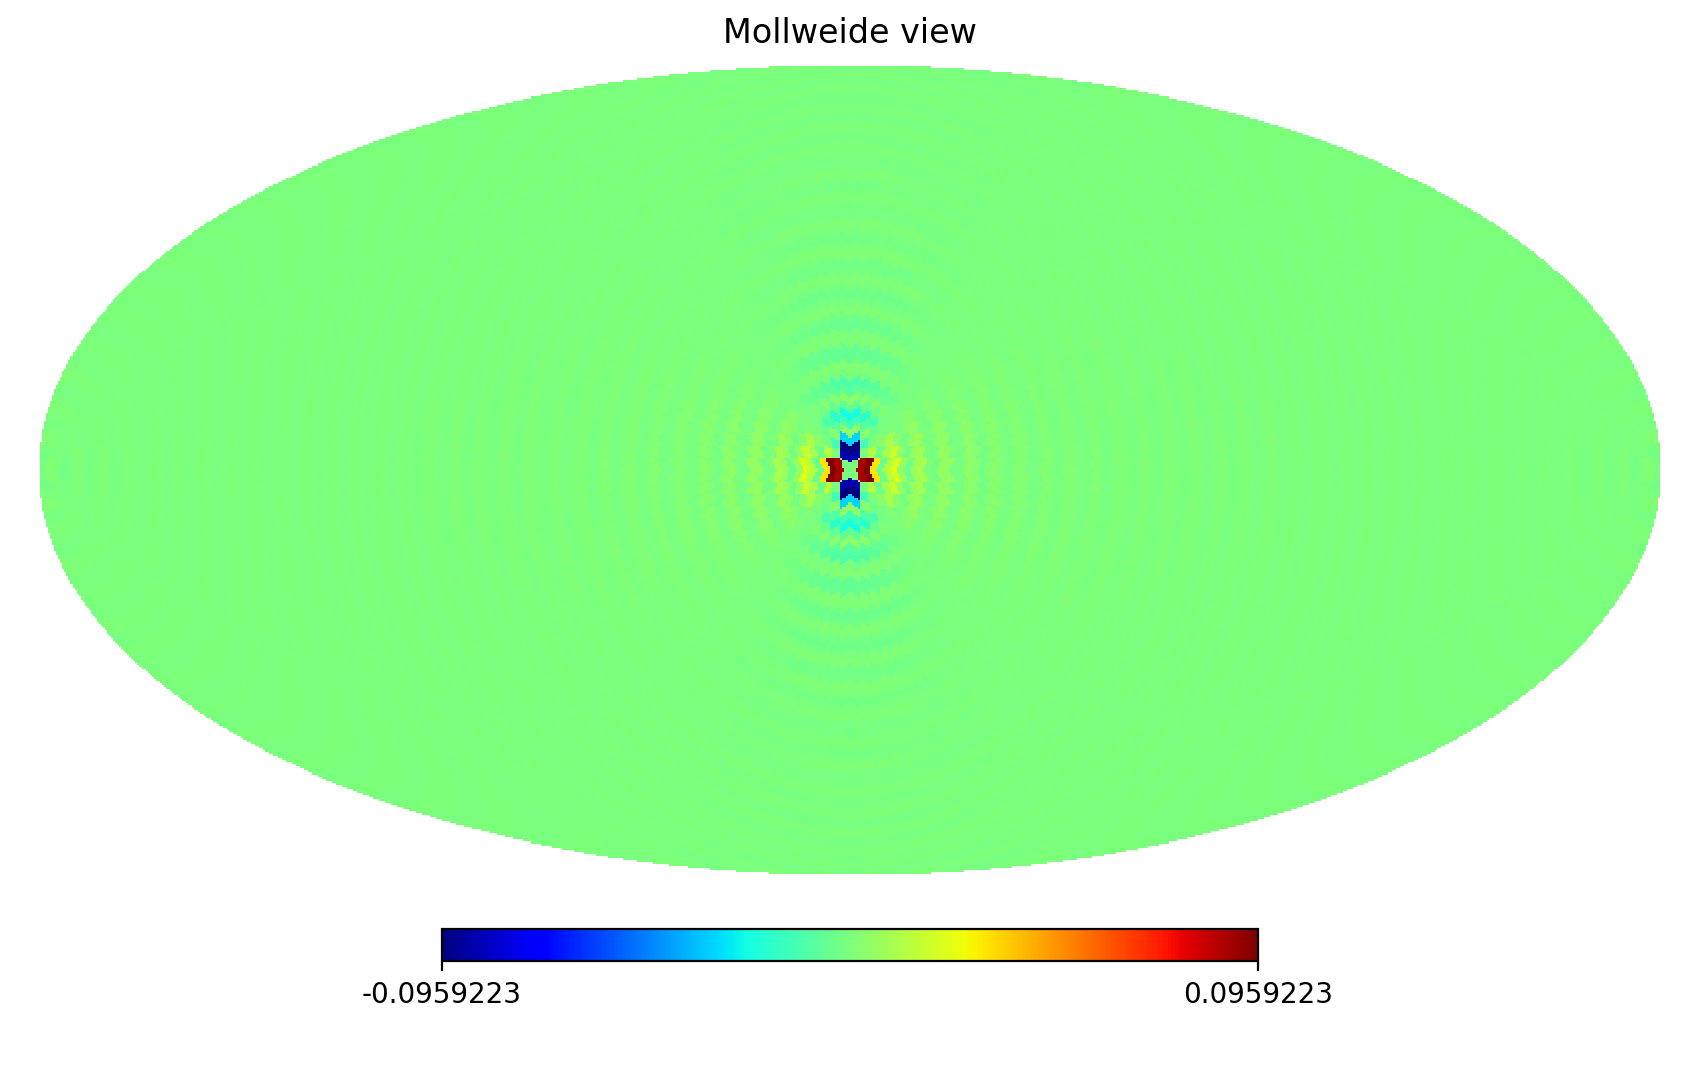

In [83]:
h.mollview(temp,rot=(0,90))

In [84]:
#h.gnomview(rteb[1]+teb[1],rot=(phi0*180./pi,90-theta0*180./pi),xsize=400,reso=15)
#h.gnomview(teb[1],rot=(phi0*180./pi,90-theta0*180./pi),xsize=400,reso=15)

In [85]:
#ralm=h.map2alm(rteb,lmax=lmax)
#ralm=[h.almxfl(ralm[i],1./gl,inplace=True) for i in range(3)]
#rteb=h.alm2map(ralm,nside)

In [86]:
clrteb=h.alm2cl(h.map2alm(rteb*mask,lmax=lmax,pol=False))
clrtebo=h.alm2cl(h.map2alm(rtebo*mask,lmax=lmax,pol=False))
cl=h.alm2cl(h.map2alm(teb*mask,lmax=lmax,pol=False))

<IPython.core.display.Javascript object>


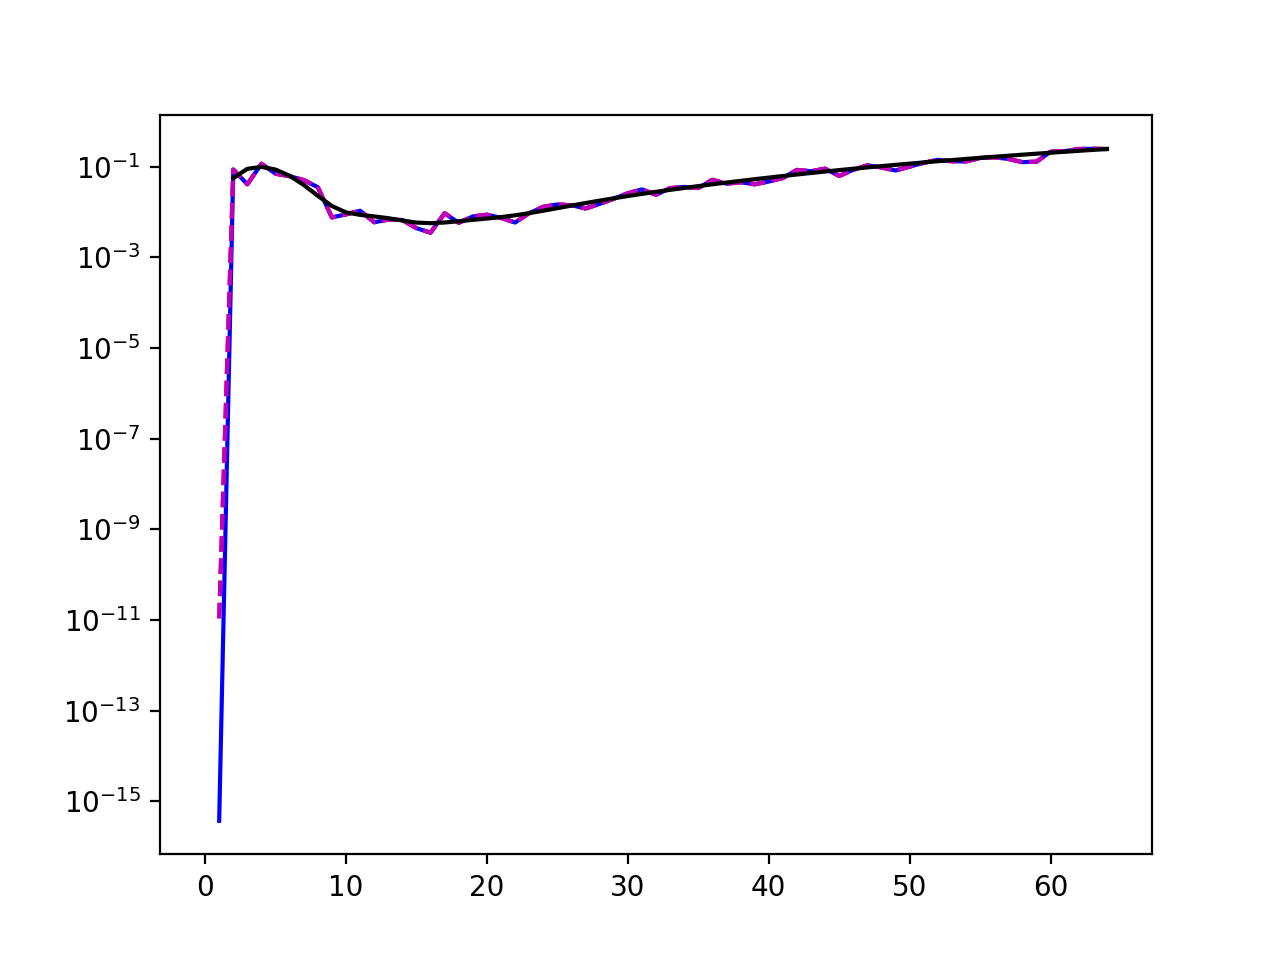

<IPython.core.display.Javascript object>


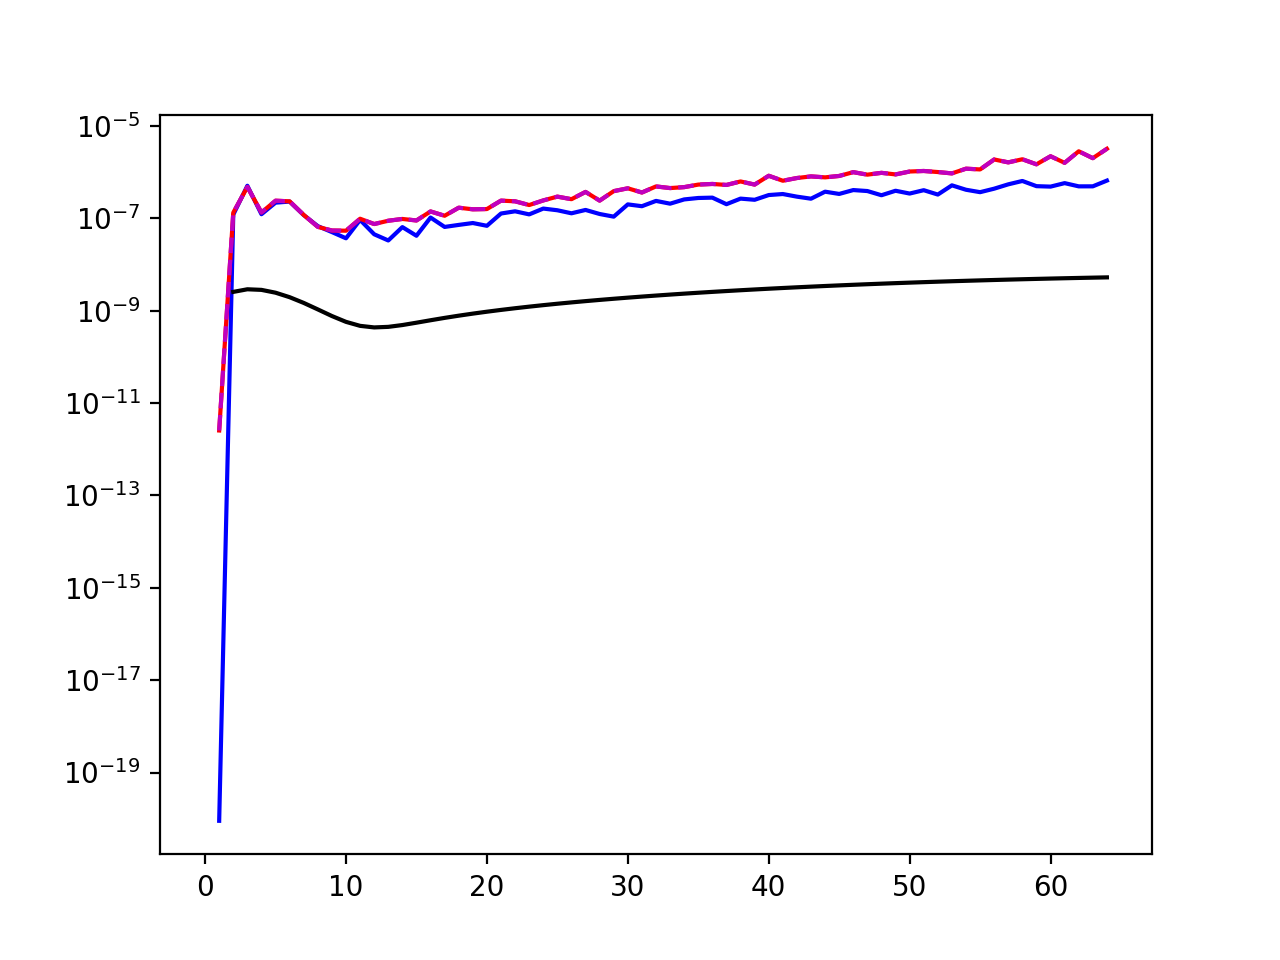

[]

In [87]:
ell=arange(lmax+1)
fll=ell*(ell+1)/(2.*pi)

figure()
plot(ell,fll*cl[1]/fsky,"b-")
plot(ell,fll*clrteb[1]/(fsky),"r--")
plot(ell,fll*clrtebo[1]/(fsky),"m--")
plot(ell,fll*cllens[1][:lmax+1],"k-")
semilogy()
#ylim(1e-4,70)

figure()
plot(ell,fll*cl[2]/fsky,"b-")
plot(ell,fll*clrteb[2]/(fsky),"r-")
plot(ell,fll*clrtebo[2]/(fsky),"m--")
plot(ell,fll*cltemp[2][:lmax+1],"k-")
semilogy()
#ylim(1e-9,1e-3)

<IPython.core.display.Javascript object>


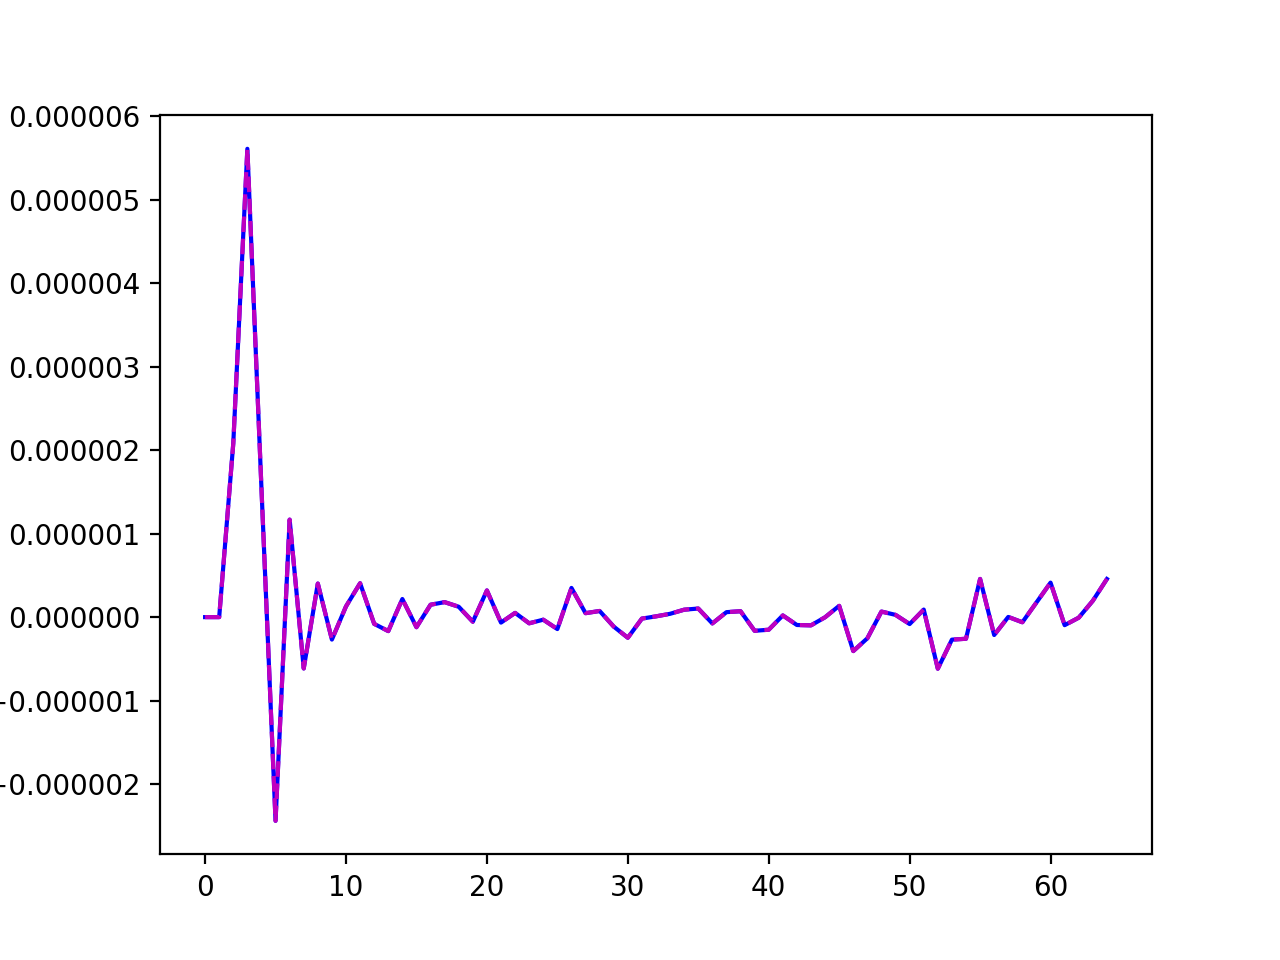

<IPython.core.display.Javascript object>


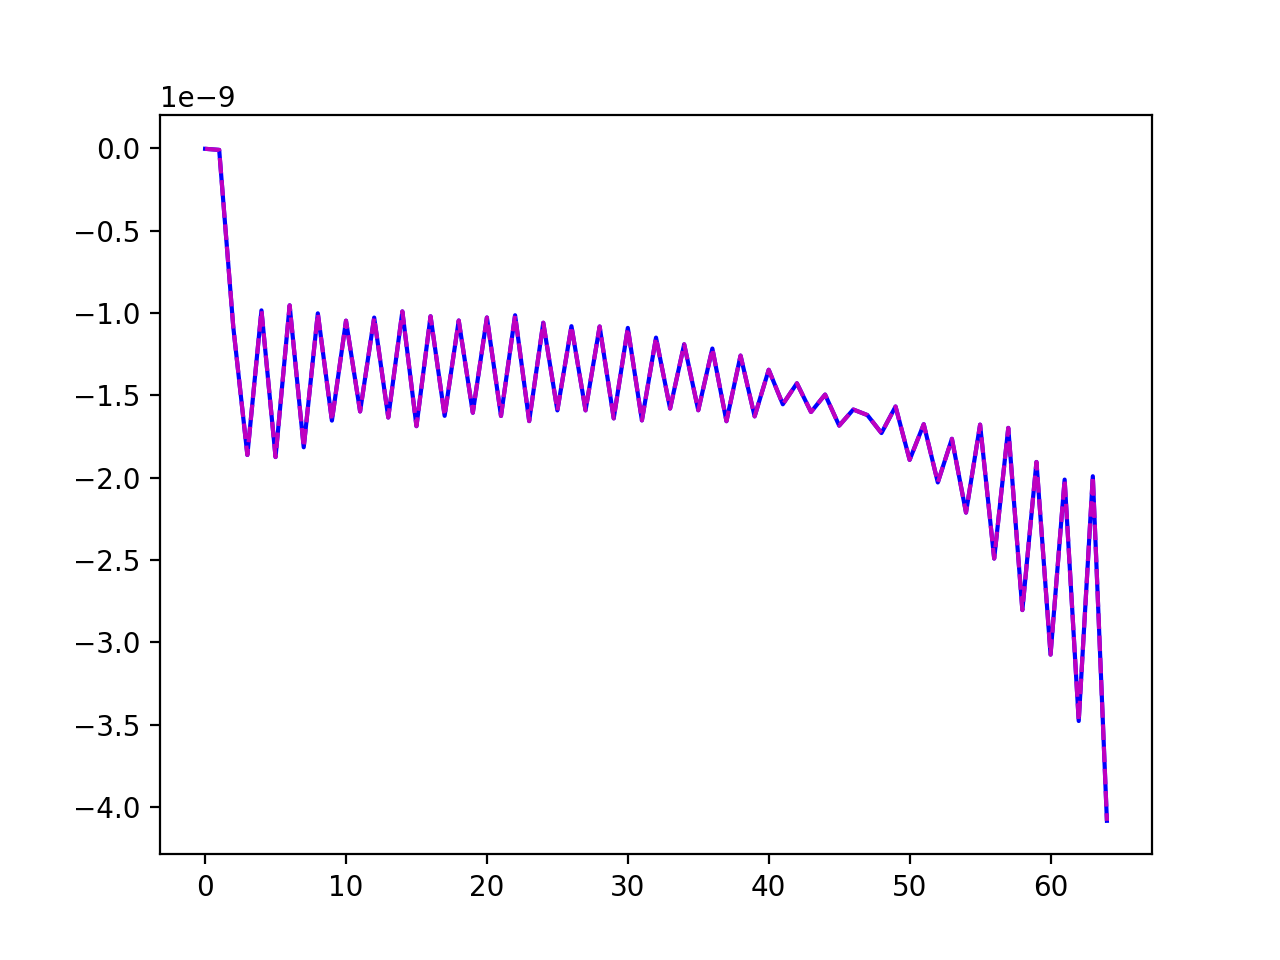

In [53]:
figure()
plot(ell,cl[1]-clrteb[1],"b-")
plot(ell,cl[1]-clrtebo[1],"m--")
#semilogy()
#ylim(1e-4,70)
figure()
plot(ell,cl[2]-clrteb[2],"b-")
plot(ell,cl[2]-clrtebo[2],"m--")


<IPython.core.display.Javascript object>


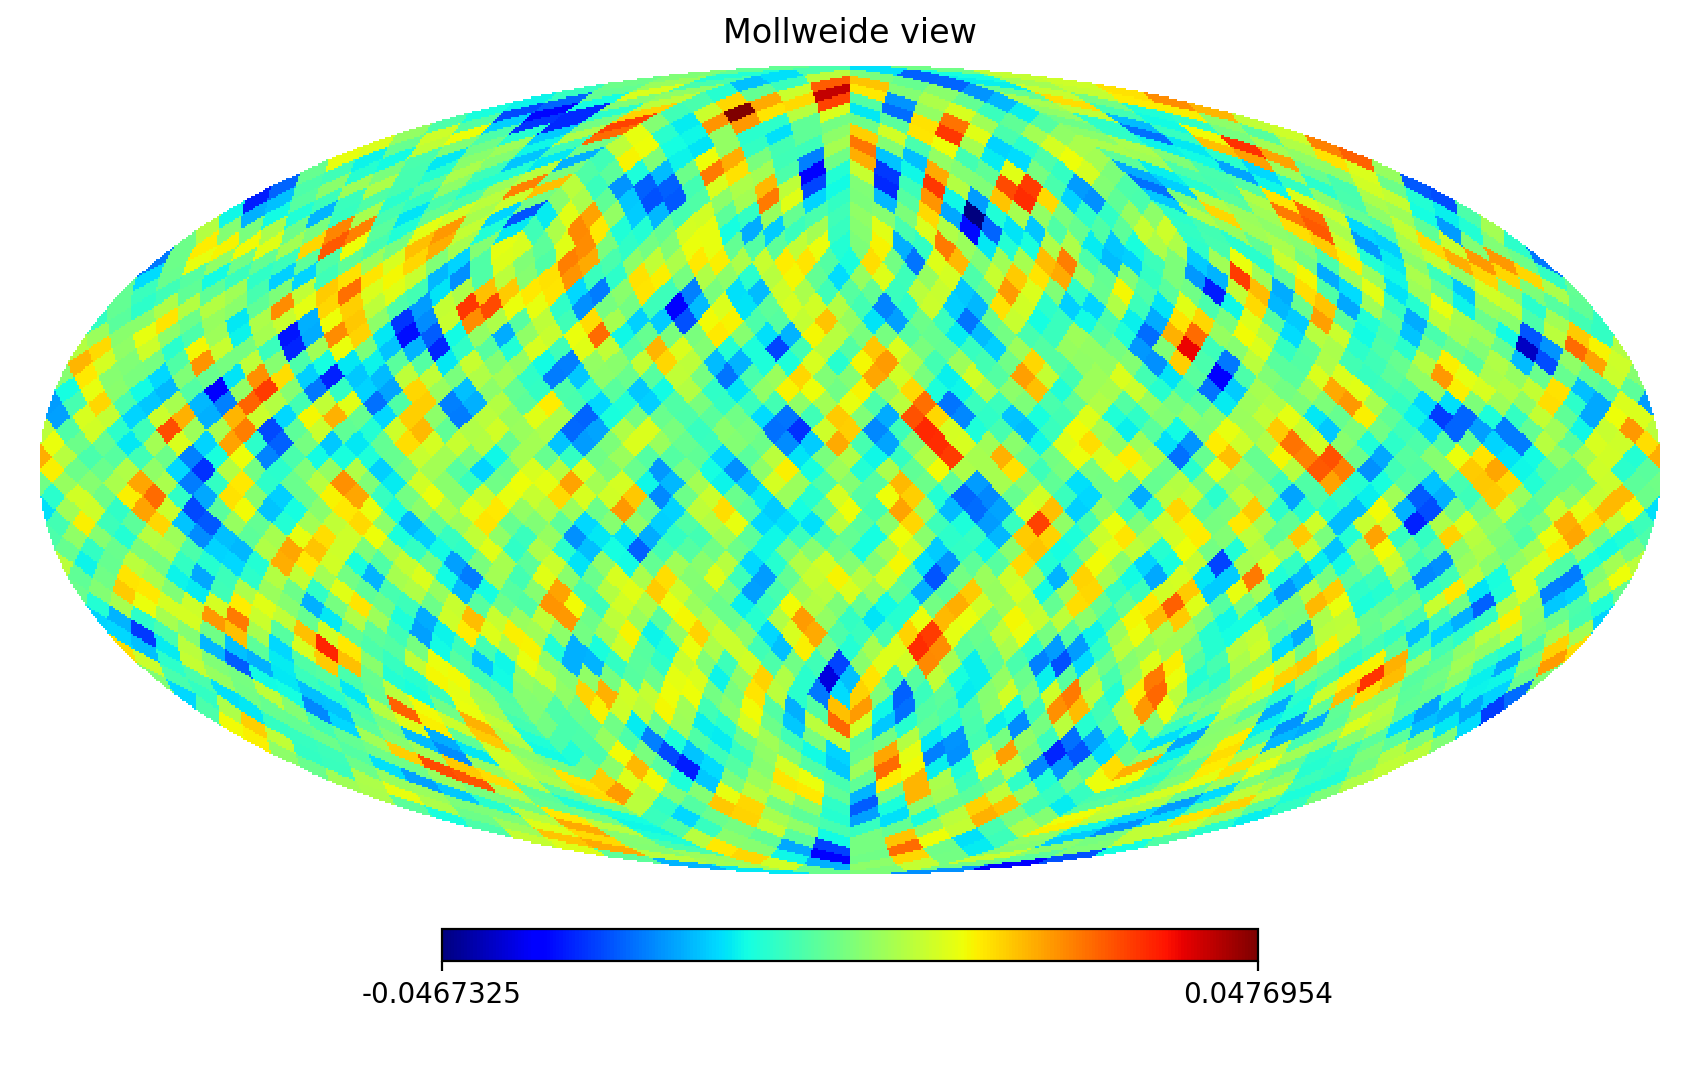

<IPython.core.display.Javascript object>


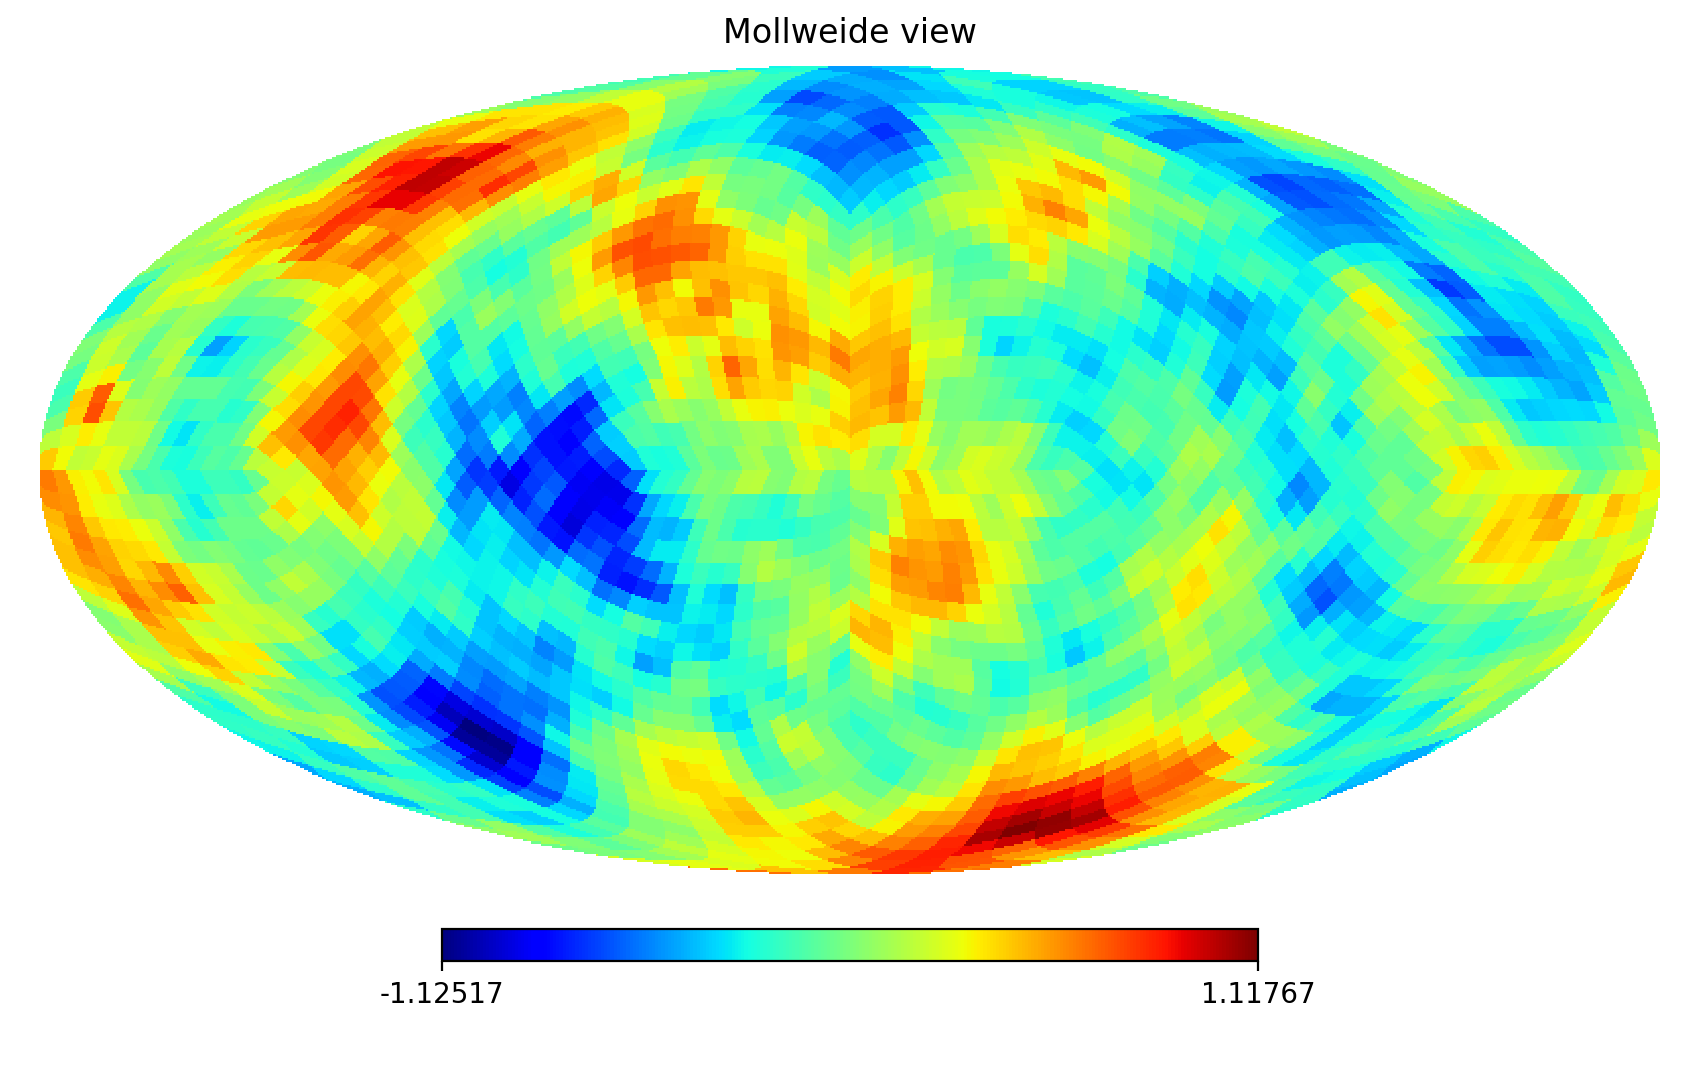

In [29]:
h.mollview(rteb[2],rot=(0,0))
h.mollview(rtebo[1],rot=(0,90))